In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils
import scipy.signal as signal

In [2]:
dask.config.set(**{'array.slicing.split_large_chunks': False})

## Import data and calculate GF

In [3]:
#define our output grid size

ds_nbp_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-89.5, 90.5, 1.0)),
        "lon": (["lon"], np.arange(0.625, 360., 1.25)),
        "lat_b": (["lat_b"], np.arange(-90.,91.,1.0)),
        "lon_b":(["lon_b"], np.arange(0, 361, 1.25))
    }
)

A_nbp = utils.find_area(ds_nbp_out, R = 6.3781e6) #convert to m2

In [4]:
#define our output grid size

ds_fgco2_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-89.5, 90.5, 1.0)),
        "lon": (["lon"], np.arange(0.5, 360, 1)),
        "lat_b": (["lat_b"], np.arange(-90.,91.,1.0)),
        "lon_b":(["lon_b"], np.arange(.5, 361.5, 1.0))
    }
)

A_fgco2 = utils.find_area(ds_fgco2_out, R = 6.3781e6) #convert to m2

In [5]:
model_run_control_dict = {
                         'CANESM5_p2':'CanESM5_piControl_r1i1p2f1*',
                          'CANESM5_p1':'CanESM5_piControl_r1i1p1f1*',
                         }

model_run_pulse_dict = {
                       'CANESM5_r1':'CanESM5_esm-pi-CO2pulse_r1i1p2f1*',
                       'CANESM5_r2':'CanESM5_esm-pi-CO2pulse_r2i1p2f1*',
                       'CANESM5_r3':'CanESM5_esm-pi-CO2pulse_r3i1p2f1*'}

model_run_1pct_dict = {
                     'CANESM5_r1p2':'CanESM5_1pctCO2_r1i1p2f1*',
                     'CANESM5_r2p2':'CanESM5_1pctCO2_r2i1p2f1*',
                     'CANESM5_r3p2':'CanESM5_1pctCO2_r3i1p2f1*',
                     'CANESM5_r1p1':'CanESM5_1pctCO2_r1i1p1f1*',
                      'CANESM5_r2p1':'CanESM5_1pctCO2_r2i1p1f1*',
                     'CANESM5_r3p1':'CanESM5_1pctCO2_r3i1p1f1*'}

In [6]:
#define our output grid size

ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-89.5, 90.5, 1.0)),
        "lon": (["lon"], np.arange(0, 360, 1)),
        "lat_b": (["lat_b"], np.arange(-90.,91.,1.0)),
        "lon_b":(["lon_b"], np.arange(.5, 361.5, 1.0))
    }
)
A = utils.find_area(ds_out, R = 6.3781e6)

In [7]:
fg_co2_1pct = {}
fg_co2_pictrl = {}
nbp_1pct = {}
nbp_pictrl = {}
co2_1pct = {}
co2_pictrl = {}

In [8]:
model_run_1pct_dict.keys()

dict_keys(['CANESM5_r1p2', 'CANESM5_r2p2', 'CANESM5_r3p2', 'CANESM5_r1p1', 'CANESM5_r2p1', 'CANESM5_r3p1'])

In [9]:


for m in model_run_1pct_dict.keys():
    print(m)
    print('load 1pct run')
   
   # if m == 'UKESM1_r1' or m == 'UKESM1_r2' or m == 'UKESM1_r3' or m == 'UKESM1_r4' or m == 'NORESM2' or m == 'MIROC' or m == 'CANESM5_r1' or m == 'CANESM5_r2' or m == 'CANESM5_r3' or m == 'CANESM5_r4' or m == 'CANESM5_r5' or m == 'ACCESS':
    print('fgco2')
    fg_co2_1pct[m] = xr.open_mfdataset(f'cmip6_data/fgco2_Omon_{model_run_1pct_dict[m]}', use_cftime=True) #kg/m2/s
    fg_co2_1pct[m] = utils._regrid_ds(fg_co2_1pct[m], ds_out)

    print('nbp')
    nbp_1pct[m] = xr.open_mfdataset(f'cmip6_data/nbp_Lmon_{model_run_1pct_dict[m]}', use_cftime=True) #kg/m2/s
    nbp_1pct[m] = utils._regrid_ds(nbp_1pct[m], ds_out)

    #if m == 'CANESM5_r1p2' or m == 'CANESM5_r2p2' or m == 'CANESM5_r3p2' or  m == 'CANESM5_r1p1' or m == 'CANESM5_r2p1' or m == 'CANESM5_r3p1':
        #print('co2mass')
        #co2_1pct[m] = xr.open_mfdataset(f'cmip6_data/co2mass_Amon_{model_run_1pct_dict[m]}', use_cftime=True) #kg
 

CANESM5_r1p2
load 1pct run
fgco2


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


nbp


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r2p2
load 1pct run
fgco2


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


nbp


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r3p2
load 1pct run
fgco2


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


nbp


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r1p1
load 1pct run
fgco2


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


nbp


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r2p1
load 1pct run
fgco2


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


nbp


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r3p1
load 1pct run
fgco2


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


nbp


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [10]:
for m in model_run_control_dict.keys():
    print(m)
    print('load pi control run')
    fg_co2_pictrl[m] = xr.open_mfdataset(f'cmip6_data/fgco2_Omon_{model_run_control_dict[m]}',use_cftime=True, engine = 'netcdf4') #kg/m2/s
    fg_co2_pictrl[m] = utils._regrid_ds(fg_co2_pictrl[m], ds_out)
    nbp_pictrl[m] = xr.open_mfdataset(f'cmip6_data/nbp_Lmon_{model_run_control_dict[m]}',use_cftime=True, engine = 'netcdf4') #kg/m2/s
    nbp_pictrl[m] = utils._regrid_ds(nbp_pictrl[m], ds_out)

#     if m == 'UKESM1' or m == 'NORESM2' or m == 'GFDL':
#         co2_pictrl[m] = xr.open_mfdataset(f'cmip6_data/co2mass_Amon_{model_run_control_dict[m]}',use_cftime=True, engine = 'netcdf4') #kg



CANESM5_p2
load pi control run


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_p1
load pi control run


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


#convert kg to kg/year
for m in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4']:
    seconds_per_yr = 60*60*24*365
    co2_1pct[m]['G_atm'] = co2_1pct[m]['co2mass'].diff('time')/(co2_1pct[m]['time'].diff('time').astype('float64')/(1e9*seconds_per_yr)) #convert from ns to year via 1e9ns/s x 60s/min x 60min/hr x 24hr/day x 365day/yr
    
for m in ['UKESM1']:
    seconds_per_yr = 60*60*24*365
    co2_pictrl[m]['G_atm'] = co2_pictrl[m]['co2mass'].diff('time')/(co2_pictrl[m]['time'].diff('time').astype('float64')/(1e9*seconds_per_yr)) #convert from ns to year via 1e9ns/s x 60s/min x 60min/hr x 24hr/day x 365day/yr

for m in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4']:
    nbp_1pct[m]['time'] = nbp_pictrl['UKESM1']['time'][:1800]
    fg_co2_1pct[m]['time'] = fg_co2_pictrl['UKESM1']['time'][:1800]
    co2_1pct[m]['time'] = co2_pictrl['UKESM1']['time'][:1800]




    if m == 'CANESM5_r1p2' or m == 'CANESM5_r2p2' or m == 'CANESM5_r3p2':
        print('co2mass')
        co2_1pct[m] = xr.open_mfdataset(f'cmip6_data/co2mass_Amon_{model_run_1pct_dict[m]}', use_cftime=True) #kg
    elif m == 'CANESM5_r1p1' or m == 'CANESM5_r2p1' or m == 'CANESM5_r3p1':
        print('co2mass')
        co2_1pct[m] = xr.open_mfdataset(f'cmip6_data/co2mass_Amon_{model_run_1pct_dict[C]}', use_cftime=True) #kg 

In [11]:
for m1 in model_run_1pct_dict.keys():
    if m1 == 'CANESM5_r1p2' or m1 == 'CANESM5_r2p2' or m1 == 'CANESM5_r3p2':
        m2 = 'CANESM5_p2'
    elif m1 == 'CANESM5_r1p1' or m1 == 'CANESM5_r2p1' or m1 == 'CANESM5_r3p1':
        m2 = 'CANESM5_p1'
    else:
        m2 = m1
    fg_co2_1pct[m1]['time'] = fg_co2_pictrl[m2]['time'][:len(fg_co2_1pct[m1]['time'])]
    nbp_1pct[m1]['time'] = nbp_pictrl[m2]['time'][:len(nbp_1pct[m1]['time'])]


In [29]:
fg_co2 = {}
nbp = {}
seconds_per_yr = 60*60*24*365
for m1 in model_run_1pct_dict.keys():
    if m1 == 'CANESM5_r1p2' or m1 == 'CANESM5_r2p2' or m1 == 'CANESM5_r3p2':
        m2 = 'CANESM5_p2'
    elif m1 == 'CANESM5_r1p1' or m1 == 'CANESM5_r2p1' or m1 == 'CANESM5_r3p1':
        m2 = 'CANESM5_p1'
    else:
        m2 = m1
    print(m1, m2)
    fg_co2[m1] = fg_co2_1pct[m1] - fg_co2_pictrl[m2]
    nbp[m1] = nbp_1pct[m1] - nbp_pictrl[m2]
    fg_co2[m1]['fgco2'] = fg_co2[m1]['fgco2']*seconds_per_yr*A
    nbp[m1]['nbp'] = nbp[m1]['nbp']*seconds_per_yr*A

CANESM5_r1p2 CANESM5_p2
CANESM5_r2p2 CANESM5_p2
CANESM5_r3p2 CANESM5_p2
CANESM5_r1p1 CANESM5_p1
CANESM5_r2p1 CANESM5_p1
CANESM5_r3p1 CANESM5_p1


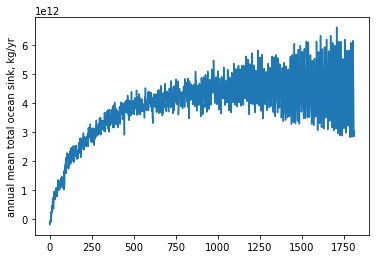

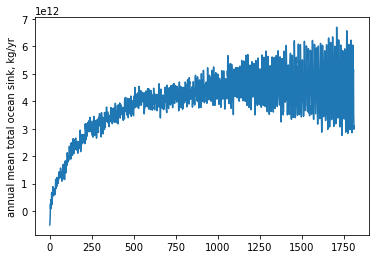

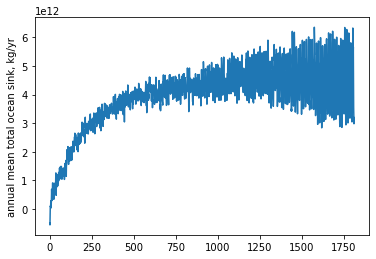

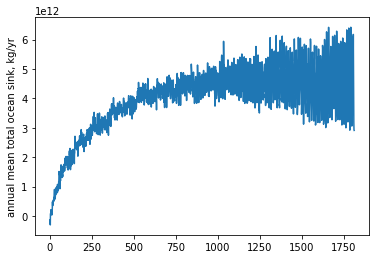

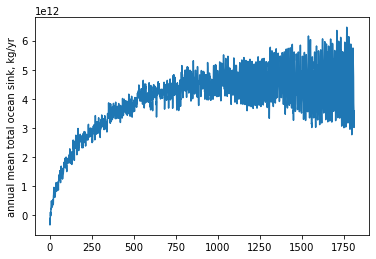

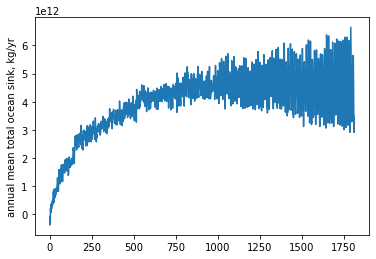

In [30]:
for m in model_run_1pct_dict.keys():
    fig, ax = plt.subplots()
    plt.plot(fg_co2[m]['fgco2'].sum(dim = ['lat','lon']))
    plt.ylabel('annual mean total ocean sink, kg/yr')

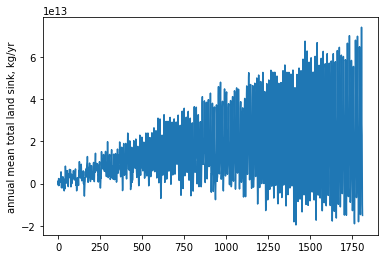

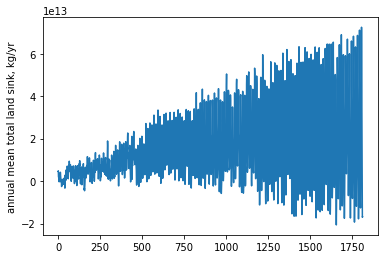

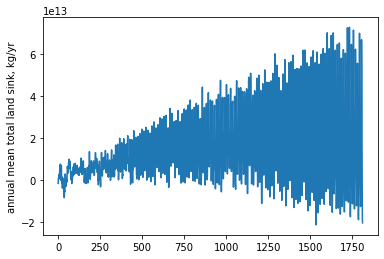

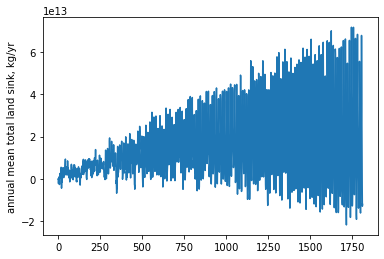

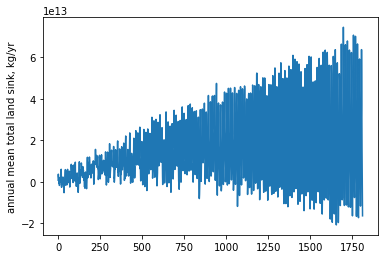

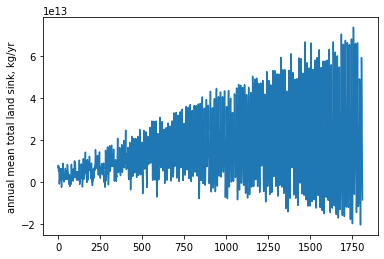

In [31]:
for m in model_run_1pct_dict.keys():
    fig, ax = plt.subplots()
    plt.plot(nbp[m]['nbp'].sum(dim = ['lat','lon']))
    plt.ylabel('annual mean total land sink, kg/yr')

In [32]:
#total sinks

emis_sinks = {}
for m in nbp.keys():
    emis_sinks[m] = nbp[m]['nbp'].sum(dim = ['lat','lon']) + fg_co2[m]['fgco2'].sum(dim = ['lat','lon'])

In [33]:
#fix the times to all be the same

for m in nbp.keys():
    times = pd.date_range('2000', periods=len(emis_sinks[m]['time']), freq='MS')
    weights = times.shift(1, 'MS') - times
    weights = xr.DataArray(weights, [('time', emis_sinks[m]['time'].values)]).astype('float')
    emis_sinks[m] =  (emis_sinks[m] * weights).groupby('time.year').sum('time')/weights.groupby('time.year').sum('time')


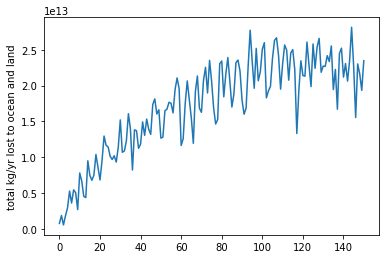

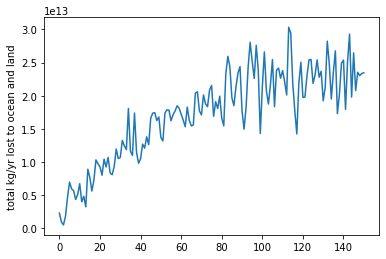

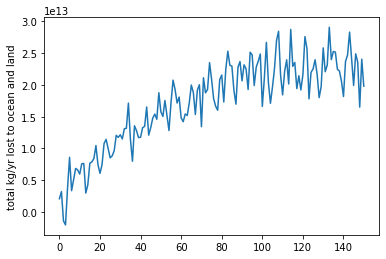

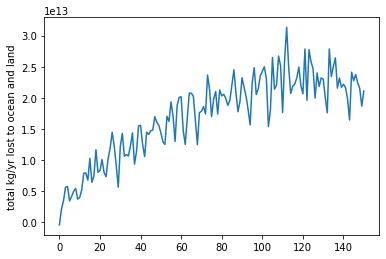

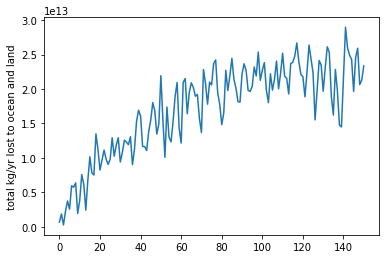

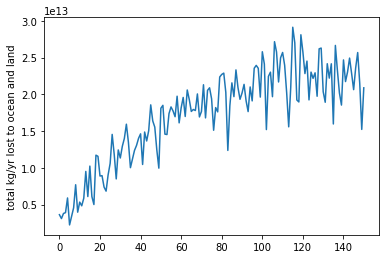

In [34]:
for m in emis_sinks.keys():
    fig, ax = plt.subplots()
    plt.plot(emis_sinks[m])
    plt.ylabel('total kg/yr lost to ocean and land')

In [39]:
co2_m = utils.compound_mult(2.21e15,151, .01) - 2.21e15

In [40]:
G_atm = np.diff(co2_m)

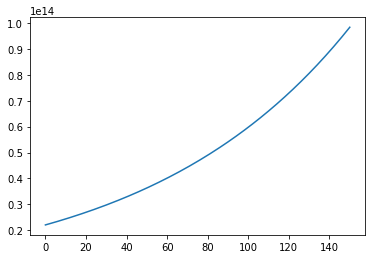

In [41]:
plt.plot(G_atm)

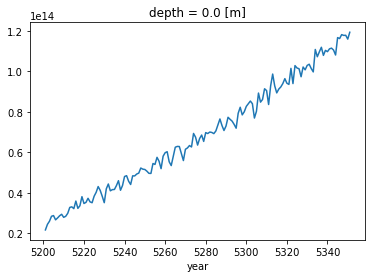

In [42]:
(G_atm+ emis_sinks['CANESM5_r1p1']).plot()

In [43]:
emis_co2 = {}
emis_co2_rolling10 = {}
emis_co2_rolling20 = {}

for m in emis_sinks.keys():
        emis_co2[m] = G_atm + emis_sinks[m]
        emis_co2_rolling10[m] = emis_co2[m].rolling(year = 10).mean(center = True).dropna("year") #G_atm[m].rolling(year = 10).mean(center = True).dropna("year") + emis_sinks[m].rolling(year = 10).mean(center = True).dropna("year")
        emis_co2_rolling20[m] = emis_co2[m].rolling(year = 20).mean(center = True).dropna("year") #G_atm[m].rolling(year = 20).mean(center = True).dropna("year") + emis_sinks[m].rolling(year = 20).mean(center = True).dropna("year")


In [44]:
kg_CO2_to_GtC = 1/(1e12*3.67)

In [45]:
emis_co2_GtC = {}
emis_co2_GtC_rolling10 = {}
emis_co2_GtC_rolling20 = {}

for m in emis_co2.keys():
    emis_co2_GtC[m] = emis_co2[m]*kg_CO2_to_GtC
    emis_co2_GtC_rolling10[m] = emis_co2_rolling10[m]*kg_CO2_to_GtC
    emis_co2_GtC_rolling20[m] = emis_co2_rolling20[m]*kg_CO2_to_GtC

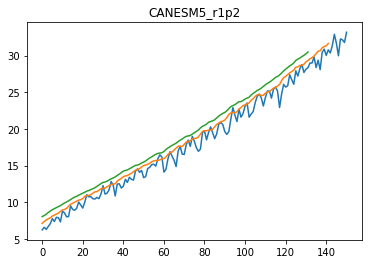

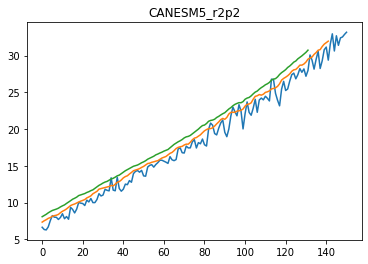

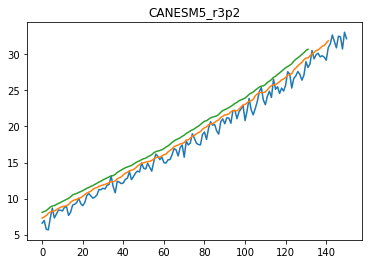

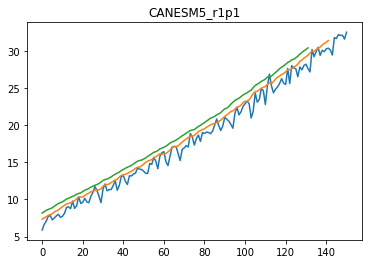

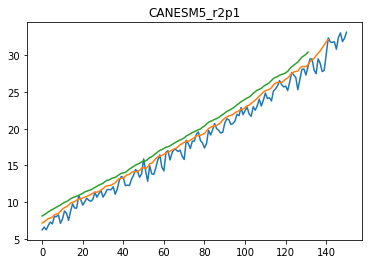

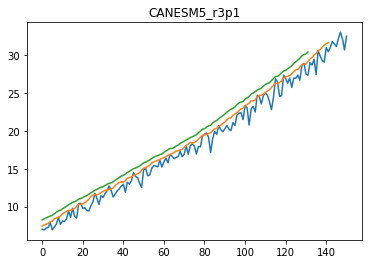

In [46]:
for m in emis_co2_GtC.keys():
    fig, ax = plt.subplots()
    plt.plot(emis_co2_GtC[m]) #Gt/yr
    plt.plot(emis_co2_GtC_rolling10[m]) #Gt/yr
    plt.plot(emis_co2_GtC_rolling20[m]) #Gt/yr
    plt.title(m)

In [47]:
for m in emis_co2_GtC.keys():
    emis_co2_GtC[m]['year'] = np.arange(0,len(emis_co2_GtC[m]['year']))
    emis_co2_GtC_rolling10[m]['year'] = np.arange(0,len(emis_co2_GtC_rolling10[m]['year']))
    emis_co2_GtC_rolling20[m]['year'] = np.arange(0,len(emis_co2_GtC_rolling20[m]['year']))

In [48]:
emis_co2_GtC_ds = xr.concat([emis_co2_GtC[m] for m in emis_co2_GtC.keys()], pd.Index([m for m in emis_co2_GtC.keys()], name='model'), coords='minimal')
emis_co2_GtC_rolling10_ds = xr.concat([emis_co2_GtC_rolling10[m] for m in emis_co2_GtC_rolling10.keys()], pd.Index([m for m in emis_co2_GtC_rolling10.keys()], name='model'), coords='minimal')
emis_co2_GtC_rolling20_ds = xr.concat([emis_co2_GtC_rolling20[m] for m in emis_co2_GtC_rolling20.keys()], pd.Index([m for m in emis_co2_GtC_rolling20.keys()], name='model'), coords='minimal')


In [49]:
emis_co2_GtC_ds

<xarray.DataArray (model: 6, year: 151)>
dask.array<concatenate, shape=(6, 151), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
    depth    float64 0.0
  * year     (year) int64 0 1 2 3 4 5 6 7 8 ... 143 144 145 146 147 148 149 150
  * model    (model) object 'CANESM5_r1p2' 'CANESM5_r2p2' ... 'CANESM5_r3p1'

# Save out CO2 emissions

In [50]:
emis_co2_GtC_ds.to_netcdf('CanESM5_1pct_emis_profile.nc4')


#np.savetxt('1pct_emis_profile_derived.csv', np.array(list(E_base.values())), delimiter=',')
#np.savetxt('1pct_emis_profile_rcp85.csv', np.array(list(E_85.values())), delimiter=',')
np.savetxt('1pct_emis_profile.csv', np.array(emis_co2_GtC_ds))
np.savetxt('1pct_emis_profile_rolling10.csv', np.array(emis_co2_GtC_rolling10_ds))
np.savetxt('1pct_emis_profile_rolling20.csv', np.array(emis_co2_GtC_rolling20_ds))

In [ ]:
emis_co2_GtC_rolling10_ds.to_netcdf('1pct_emis_profile_rolling10.nc4')
emis_co2_GtC_rolling20_ds.to_netcdf('1pct_emis_profile_rolling20.nc4')